# Biostat 216 Final Project: Predicting Wine Quality Using Machine Learning!
Author: Sebastián Cruz González
<br>
March 18, 2022

In this notebook I will be perform some machine learning analyses to predict the quality of various wines using physicochemical features as predictors. This dataset was obtained from a Kaggle post by user "M Yasser H", and the data can be accessed using this link: https://www.kaggle.com/yasserh/wine-quality-dataset

## Introduction

Wine is an extremely popular alcoholic drink produced from fermented grapes. It has been produced for many millennia and has accompanied human civilization all the way from ancient China, through ancient Egypt, and the Greeks and Romans. It even makes important appearances in Christianity, with it being an 
important component of the Eucharist, an important Christian rite. In the present, wine is a widely consumed alcoholic drink mostly relegated to social settings, but it is also consumed in more "exploratory" settings where people gather to taste various wines, highlighting taste notes particular to certain wines and scoring them. This has become a popular practice due to the sheer complexity of this drink, as well as the wide variety of wines that exist. Certain regions of the world have even developed their own "styles" of wine, gaining quite a bit of popularity and culinary tourism. Such examples include the Napa Valley right here in Northern California, as well as Northern Portugal. The latter is particularly famous for its "Vinho Verde", which is very acidic, subtly carbonated, and low on alcohol per volume. These characteristics have made this type of wine extremely popular for the Summer season, and therefore draws great crowds of wine enthusiasts to Minho, Portugal. The dataset presented herein is a collection of red variants of "Vinho Verde", with each row corresponding to a different wine. The features (columns) correspond to various physicochemical features, including alcohol percentage per volume, pH, density, among others. For this project, I will train a model on these features to predict the quality of a particular wine. This will elucidate the desireable physicochemical features that make a "good" wine.

## Methods

There are two major problems to tackle for this dataset. The first is that there is a major class imbalance, with most wines being ranked as "average" (5/10 or 6/10) rather than "excellent" (> 6/10) or "poor" (< 5/10). The second problem is these quality scorings are, in my opinion, hardly informative given the fact that they are based on sensory data. Is there really such a significant difference between a 5/10 and a 7/10 wine? I believe not. To solve both problems, I will use a binary classification based on the already available scores, classifying the wines as simply "good" or "not good". The threshold will be drawn at >=6 ("good") or < 6 ("not good"). This will transform the project into a classification task, for which we can use a standard classifier. I have chosen the XGBoost framework as these models train iteratively over multiple "weak" models, and I believe this approach will serve well for predicting on this dataset. Additionally, the XGBoost framework has built-in cross-validation and hyperparameter tuning, along with feature importance extraction, which is essential for dissecting a model and obtaining insights about our data. In this case it's particularly relevant because I want to find the physicochemical features that significantly drive a wine's quality.

## Data Wrangling

In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

/Users/sebastiancruzgonzales/opt/anaconda3/envs/python39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Import the dataset and change the quality column to one-hot encoding of "good" and "not good" (1 and 0, respectively)
wine = pd.read_csv("/Users/sebastiancruzgonzales/Documents/UCSF/Biostat 216/Wine_Quality_Project/WineQT.csv")
wine['quality_encode'] = np.where(wine['quality'] >=6, 1, np.where(wine['quality'] < 6, 0, 'nan'))


In [3]:
# Describe the dataset, providing important summary statistics for each column
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


As we can see above, there are 1,143 wines in this dataset. There is very little spread for some of these variables (as given by the standard deviation metric), but some variables have a bit more spread, such as total sulfur dioxide. Importantly, the highest score given to a wine was only 8, whereas the lowest score was a 3. The mean value was 5.
<br>

Now let's count the labels after splitting at the new threshold and one-hot encoding them.

In [4]:
wine.groupby('quality_encode').size()

quality_encode
0    522
1    621
dtype: int64

This now looks pretty balanced, although there are 99 more wines that are "good" versus "not good".
<br>

Are there missing values in the data? If so, clear them out.

In [5]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
quality_encode          0
dtype: int64

No missing values, let's keep going.

Let's visualize the distributions of the features with regards to the one-hot encoded quality variable.

<AxesSubplot:xlabel='quality_encode', ylabel='fixed acidity'>

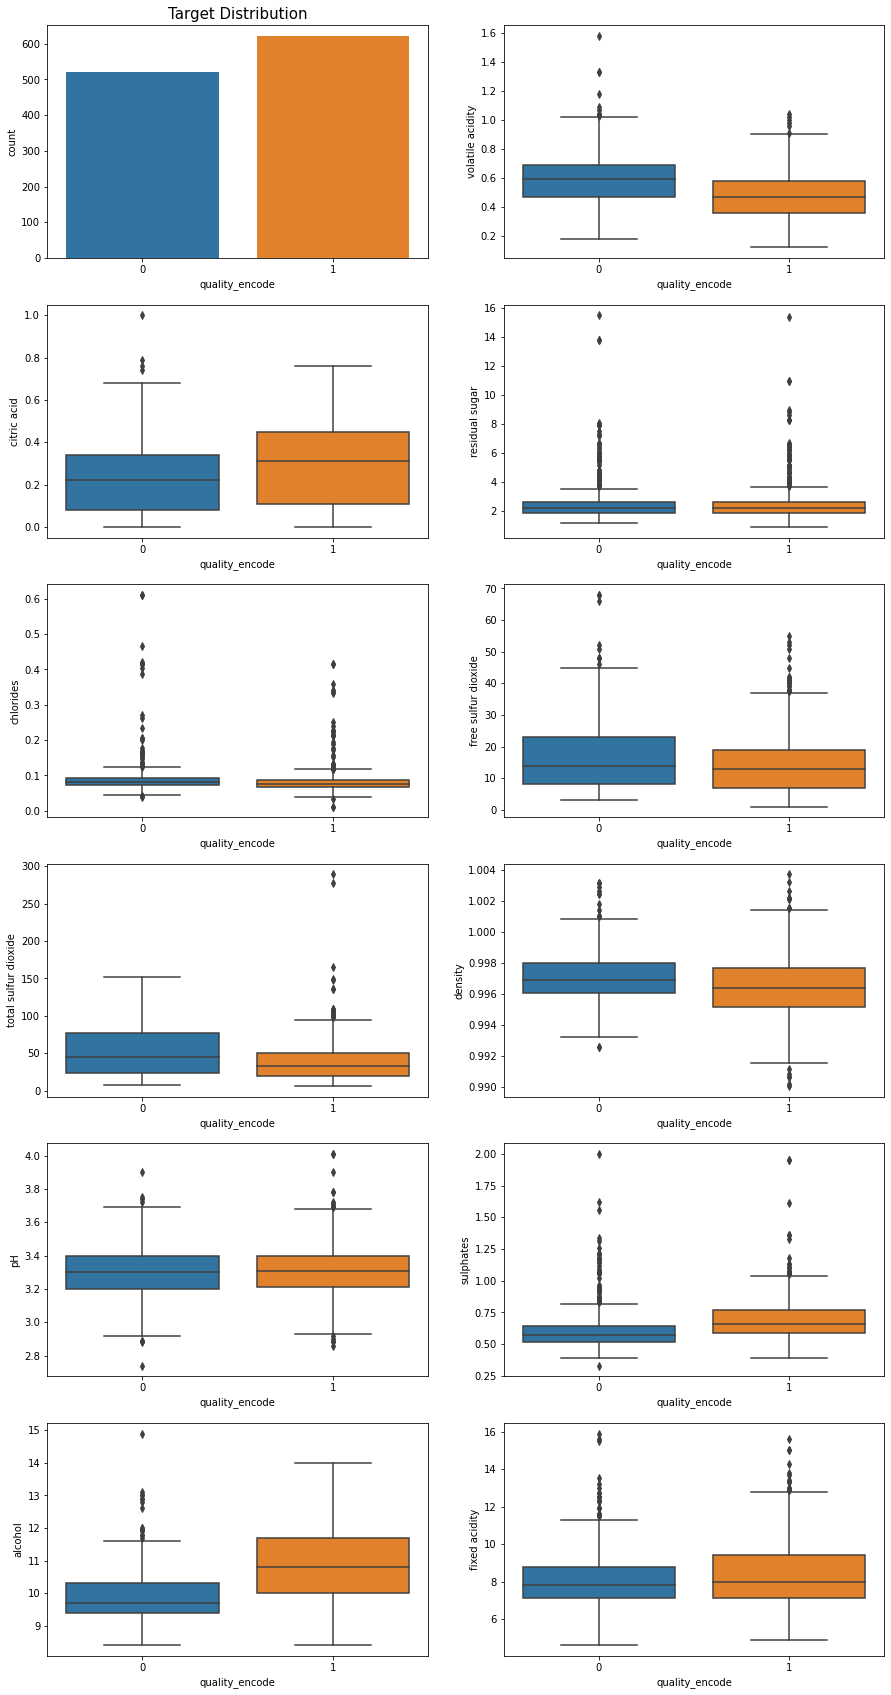

In [6]:
fig,ax=plt.subplots(6,2,figsize=(15,30))
sns.countplot(x=wine.quality_encode,ax=ax[0][0]).set_title('Target Distribution',size=15)
sns.boxplot(x=wine.quality_encode,y=wine['volatile acidity'],ax=ax[0][1])
sns.boxplot(x=wine.quality_encode,y=wine['citric acid'],ax=ax[1][0])
sns.boxplot(x=wine.quality_encode,y=wine['residual sugar'],ax=ax[1][1])
sns.boxplot(x=wine.quality_encode,y=wine['chlorides'],ax=ax[2][0])
sns.boxplot(x=wine.quality_encode,y=wine['free sulfur dioxide'],ax=ax[2][1])
sns.boxplot(x=wine.quality_encode,y=wine['total sulfur dioxide'],ax=ax[3][0])
sns.boxplot(x=wine.quality_encode,y=wine['density'],ax=ax[3][1])
sns.boxplot(x=wine.quality_encode,y=wine['pH'],ax=ax[4][0])
sns.boxplot(x=wine.quality_encode,y=wine['sulphates'],ax=ax[4][1])
sns.boxplot(x=wine.quality_encode,y=wine['alcohol'],ax=ax[5][0])
sns.boxplot(x=wine.quality_encode,y=wine['fixed acidity'],ax=ax[5][1])

Some remarks about the distributions: the "good" wines tend to have higher alcohol per volume content, as well as higher citric acid content. Also notable that the lesser rated wines have more volatile acididity and density.

We get our X feature matrix and vector of labels y.

In [7]:
wine.iloc[:, :11]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2


In [8]:
wine = wine.drop('quality', 1) # Drop the original quality column
wine = wine.drop('Id', 1) # Drop the ID column
X = wine.iloc[:, :11].values # Get just the predictors for our feature matrix
y = wine.iloc[:, 11].values # Get the labels

/var/folders/hx/cq0rjjk14xlfr_swknpyv0xr0000gn/T/ipykernel_4387/1912830162.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  wine = wine.drop('quality', 1) # Drop the original quality column
/var/folders/hx/cq0rjjk14xlfr_swknpyv0xr0000gn/T/ipykernel_4387/1912830162.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  wine = wine.drop('Id', 1) # Drop the ID column


Now we split the data into training and test sets. I'll use a typical 70/30 split, and I'll be using the train_test_split function from Scikit-Learn.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Results

Construct the XGB Classifier and train it on the data

In [10]:
wine_classifier = xgb.XGBClassifier() # Default parameters
wine_classifier.fit(X_train, y_train)

[15:48:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/sebastiancruzgonzales/opt/anaconda3/envs/python39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
y_pred = wine_classifier.predict(X_test)

We'll use the Sklearn accuracy score function to see how well our model performs.

In [12]:
accuracy = accuracy_score(y_test, y_pred)

In [13]:
accuracy

0.7510917030567685

Turns out it does pretty well!

Now let's cast the predictions to integer so we can plot a ROC curve for our model. The ROC curve will show us the performance of our model at various classification thresholds. We can use this as a good proxy for overall performance model by calculating the area under the curve (AUC).

In [14]:
y_pred = y_pred.astype(np.int)
y_test = y_test.astype(np.int)

/var/folders/hx/cq0rjjk14xlfr_swknpyv0xr0000gn/T/ipykernel_4387/3518439735.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = y_pred.astype(np.int)
/var/folders/hx/cq0rjjk14xlfr_swknpyv0xr0000gn/T/ipykernel_4387/3518439735.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

Text(0.5, 0, 'False Positive Rate')

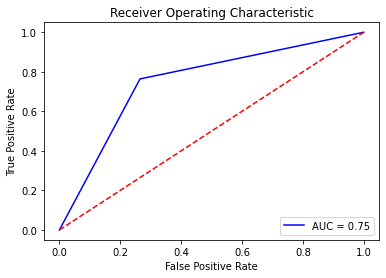

In [17]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

I'm also going to plot the feature importances for the model. This will show which features were most important for the model predicting a wine's quality.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

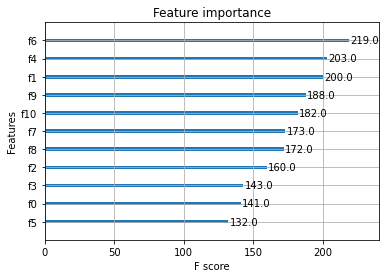

In [18]:
xgb.plot_importance(wine_classifier)

Text(0.5, 0, 'Xgboost Feature Importance')

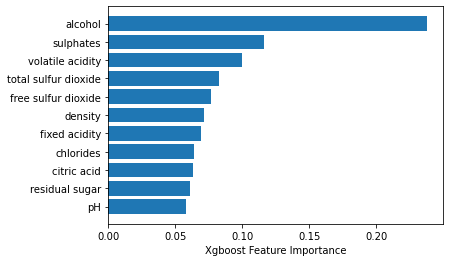

In [21]:
sorted_idx = wine_classifier.feature_importances_.argsort()
plt.barh(wine.columns[sorted_idx], wine_classifier.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

It turns out alcohol per volume was the most important determinant for the model to make its predictions!

## Discussion

In the present work, I trained a model to predict the quality of "Vinho Verde" red wine variants. This model was built on the XGBoost framework and thus consists of boosted decision trees, and it was trained on a variety of physicochemical properties tht pertained to the various wines. The model performed modestly on default parameters, but would of course be served well by some hyperparameter tuning. But above all, greater availability of training data would go a long way towards improving this model's performance, as the current dataset consists of 1,143 wines, of which only 70% are used for training and 30% for testing.
<br>

Along the way I had to change the way the quality of the wines was encoded, switching from a continuous value to a categorical encoding of "good" or "not good". The reasons for this decision are two-fold: first, it removes the problem of class imbalance for this dataset, where most wines were just "average" and almost none were "excellent" or "poor". Second, I believe this accounts for biases that people might have with regards to assigning scores. Assigning a score is a much harder task than stating if we "like" or "don't like" something. Scores are inevitably based off someone's past experiences, and when asked to place something on a scale (especially to score it) we will always find some reference and its score to give something new a score. This alternative approach simply asks, "Was the wine good or not good?", doing away with some of the structural problems behind reviewing quality. 
<br>

Through dissection of the model (feature importance analysis), I found that the model prioritized alcohol content for the wine as the most important feature in deciding the quality of a wine. There are some potential biases implicit in this, and it could be argued that it can benefit or detract from the assessment of the quality of a wine. If a wine has a higher alcohol concentration per volume, the person tasting an reviewing the wine might be more intoxicated when asked to give an opinion. On the one hand, this might influence the person to say the wine is "good" when in reality they would not like its taste while sober. On the other hand, being under the influence of alcohol might lead the reviewer to be more honest about their opinion regarding the wine, and thus the quality score would be more accurate. Access to more information about this dataset would resolve this connundrum. Such information could include how much wine each reviewer had consumed when reviewing the wines, if the reviewers were asked to give comparative or absolute scores, or even if the scores reflect a combination of multiple component scores averaged and weighted. Such robust testing approaches would give vineyards and wine producers greater insights into what they are doing correctly in terms of wine production, and what could be improved for better customer outreach. For the time being (and lacking some of this information), I would be very hesitant to conclude that "more alcohol" leads to a better wine, even if the model prioritized this feature in classifying wines.